# Assignment 4

**Assignment 4: Neural Networks**

**Goal**: ​Get familiar with neural networks by implementing them and applying them to image classification.

In this assignment we are going to learn about neural networks (NNs). The goal is to implement two neural networks: a fully-connected neural network, a convolutional neural network, and analyze their behavior.

The considered task is image classification. We consider a dataset of small natural images (see the additional file) with multiple classes. We aim at formulating a model (a neural network) and learning it using the negative log-likelihood function (i.e., the cross-entropy loss) as the objective function, and the stochastic gradient descent as the optimizer.

In this assignment, ​**the code must be implemented in PyTorch**.

## 1 Understanding the problem



The considered problem is about classifying images to $L$ classes. In the first part of the assignment, you are asked get familiar with PyTorch, a deep learning library, and the basics of neural networks, and implement neural-network-based classifiers. For this purpose, we will start with classifying small images (8px x 8px) of handwritten digits to one of 10 classes. The dataset is very small and all experiments could be achieved within a couple of minutes.

In the second part, you are asked to implement the whole pipeline for a given dataset by yourself.

Please run the code below and spend a while on analyzing the images.

If any code line is unclear to you, please read on that in numpy, scipy, matplotlib and PyTorch docs.

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset

EPS = 1.0e-7

In [ ]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# mount drive: WE NEED IT FOR SAVING IMAGES!
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
results_dir = "/content/gdrive/My_Drive/Colab Notebooks/results/"

In [ ]:
# PLEASE DO NOT REMOVE!
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

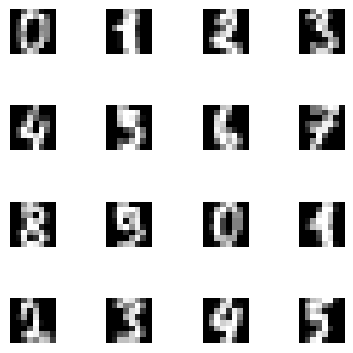

In [ ]:
# PLEASE DO NOT REMOVE
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4, 4, figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4 * i + j], (8, 8))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")

## 2 Neural Networks for Digits (4pt)

In this assignment, you are asked to implement a neural network (NN) classifier. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

### 2.1 Neural Network Classifier

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [ ]:
# PLEASE DO NOT REMOVE!
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).


# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)


# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

Below is the main class for a classifier parameterized by a neural network.

In [ ]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but it is explained badly
# 1.0 pt if code works and it is explained well
# =========
# Implement a neural network (NN) classifier.
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # output is taken from classnet
        out = self.classnet(x)
        # index of maximum value and assign it to predicted one
        _, y_pred = torch.max(out, dim=1)
        #return predicted label
        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):
        # get output from classnet 
        out = self.classnet(x)
        # compute loss from self.nll between output and y
        loss = self.nll(out, y)       
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

**Question 1 (0-0.5pt):** What is the objective function for a classification task? In other words, what is nn.NLLLoss in the code above? Pelase write it in mathematical terms.

**Answer:**
Objective function for a classification task is the negative logarithmic likelihood loss (nll). Nll tries to maximise the probability of a sample generated from target class. nn.NLLLoss in the code is the nll loss computed from input and the target. nn.NLLLoss is computed for the loss between prediction and the target class. It is the negative sum of the logarithmic probabilities of the labels. 
Formula for nllloss is:

Loss = - 1/N ∑ (i =1 to i=N ) y_i(log softmax),  y is input tensor, log softmax is done to input tensor y, N is the size of labels.

**Question 2 (0-0.5pt):** In the code above, it is said to use the logarithm of the softmax as the final activation function. Is it correct to use the log-softmax instead of the softmax for making predictions (i.e., picking the most probable label).

**Answer:** Yes it is correct to use log softmax for making predictions. log softmax could be used for final activation function. log softmax instead of softmax could be useful to avoid from underflow or overflow problems.

### 2.2 Evaluation

In [ ]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

### 2.3 Training procedure

In [ ]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

### 2.4 Experiments

#### Initialize dataloaders

In [ ]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1][0]}")
#print(f"Feature example shape: {example.shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Label example: 1


In [ ]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print("\n\nWhat happens if we reshape a feature batch? \n")
reshape = Reshape(size=(1, 8, 8))
train_features_reshaped = reshape(train_features)
print(f"Feature batch shape after reshape: {train_features_reshaped.size()}")

print("\n\nWhat happens if we flatten a reshaped feature batch? \n")
flatten = Flatten()
train_features_flattened = flatten(train_features_reshaped)
print(f"Feature batch shape after flatten: {train_features_flattened.size()}")

How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 64])
Labels batch shape: torch.Size([64])


What happens if we reshape a feature batch? 

Feature batch shape after reshape: torch.Size([64, 1, 8, 8])


What happens if we flatten a reshaped feature batch? 

Feature batch shape after flatten: torch.Size([64, 64])


#### Initialize hyperparameters

In [ ]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64  # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

#### Running experiments

In the code below, you are supposed to implement architectures for MLP and CNN. For properly implementing these architectures, you can get 0.5pt for each of them.


-> START classifier_mlp
Epoch: 0, val nll=0.9148185675484793, val ce=0.1742857142857143
Epoch: 10, val nll=0.18981209073747907, val ce=0.04285714285714286
Epoch: 20, val nll=0.14938230310167586, val ce=0.03142857142857143
Epoch: 30, val nll=0.13206408636910574, val ce=0.03142857142857143
Epoch: 40, val nll=0.1245104227747236, val ce=0.03428571428571429
Epoch: 50, val nll=0.11817247254507882, val ce=0.03142857142857143
Epoch: 60, val nll=0.11356084551130022, val ce=0.025714285714285714
Epoch: 70, val nll=0.11237153325762067, val ce=0.02857142857142857
Epoch: 80, val nll=0.11141116925648281, val ce=0.025714285714285714
Epoch: 90, val nll=0.11142386708940778, val ce=0.02857142857142857
Epoch: 100, val nll=0.1099775036743709, val ce=0.025714285714285714
Epoch: 110, val nll=0.10782670566013881, val ce=0.025714285714285714
-> FINAL PERFORMANCE: nll=0.34455900117588256, ce=0.07829977628635347


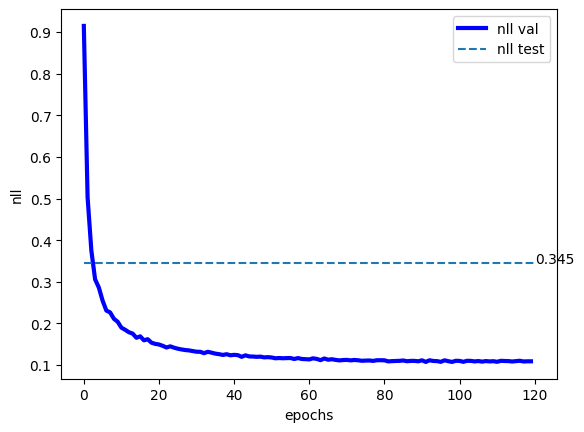

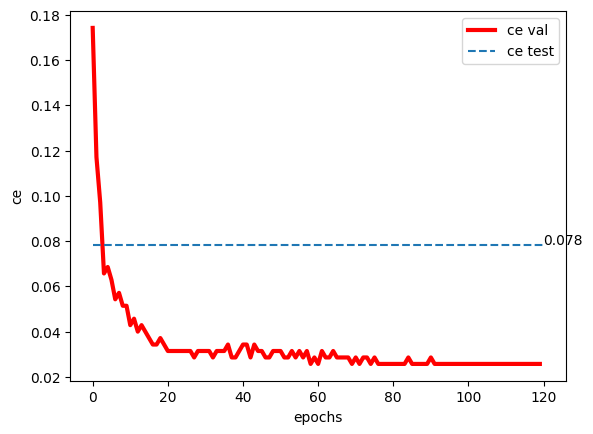


-> START classifier_cnn
Epoch: 0, val nll=1.287516871861049, val ce=0.15142857142857144
Epoch: 10, val nll=0.11044603552137103, val ce=0.03142857142857143
Epoch: 20, val nll=0.057314673832484654, val ce=0.014285714285714285
Epoch: 30, val nll=0.047614827156066894, val ce=0.008571428571428572
Epoch: 40, val nll=0.041227503504071915, val ce=0.008571428571428572
Epoch: 50, val nll=0.040044151714869906, val ce=0.008571428571428572
Epoch: 60, val nll=0.03655000899519239, val ce=0.008571428571428572
Epoch: 70, val nll=0.0326534628868103, val ce=0.008571428571428572
Epoch: 80, val nll=0.03100651102406638, val ce=0.008571428571428572
Epoch: 90, val nll=0.029798766885484967, val ce=0.008571428571428572
Epoch: 100, val nll=0.029276670004640307, val ce=0.008571428571428572
Epoch: 110, val nll=0.026831621059349605, val ce=0.005714285714285714
Epoch: 120, val nll=0.02737844350082534, val ce=0.005714285714285714
Epoch: 130, val nll=0.026539531839745386, val ce=0.005714285714285714
Epoch: 140, val n

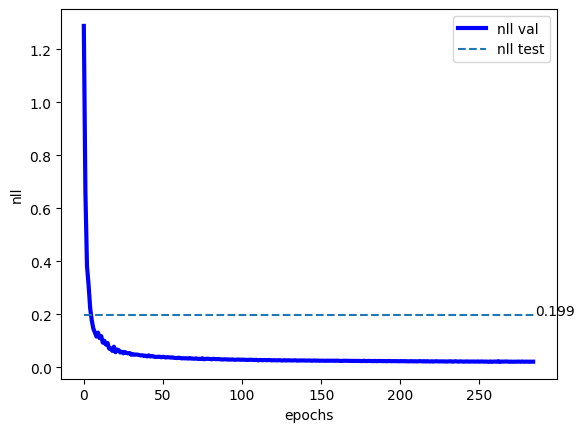

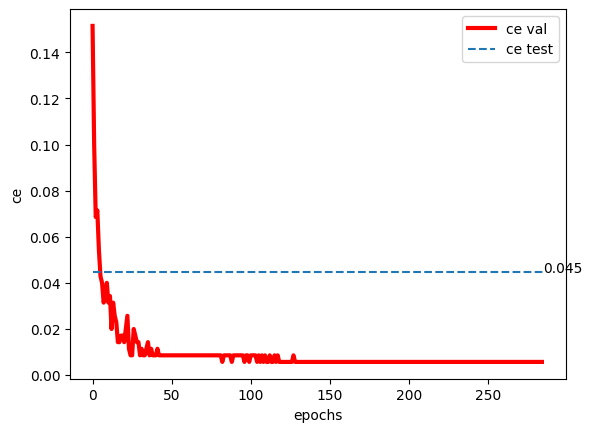

In [ ]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
# We will run two models: MLP and CNN
names = ["classifier_mlp", "classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)

    # Create a folder if necessary
    result_dir = os.path.join(results_dir, "results", name + "/")

    # =========
    # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
    result_dir = "/content/gdrive/MyDrive/Colab Notebooks/results"  # (current folder)
    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)

    # MLP
    if name[0:14] == "classifier_mlp":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        # input is D, hidden layer has M neurons, 
        # and classifier outputs a size K
        classnet = nn.Sequential(
            nn.Linear(D, M),
            nn.ReLU(),
            nn.Linear(M, K),
            nn.LogSoftmax(dim=1)
        )
        #
        # You are asked here to propose your own architecture
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        pass

    # CNN
    elif name[0:14] == "classifier_cnn":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        classnet = nn.Sequential(
            # use Reshape(size) as the first layer
            Reshape((1, 8, 8)), 
            # 2d convolutional
            nn.Conv2d(1, num_kernels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 2d convolutional
            nn.Conv2d(num_kernels, num_kernels*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            # Flatten() after all convolutional
            # layers and before linear layers.
            Flatten(),
            nn.Linear(num_kernels*8, M),
            nn.ReLU(),
            nn.Linear(M, K),
            nn.LogSoftmax(dim=1)
        )
        #
        # You are asked here to propose your own architecture
        # NOTE: Plese note that the images are represented as vectors, thus, you must
        # use Reshape(size) as the first layer, and Flatten() after all convolutional
        # layers and before linear layers.
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        pass

    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )

    # Training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=training_loader,
        val_loader=val_loader,
    )

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + "_test_loss.txt", "w")
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()
    # create curves
    plot_curve(
        result_dir + name,
        nll_val,
        file_name="_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )

## 2.5 Analysis

**Question 3 (0-0.5pt)**: Please compare the convergence of MLP and CNN in terms of the loss function and the classification error.

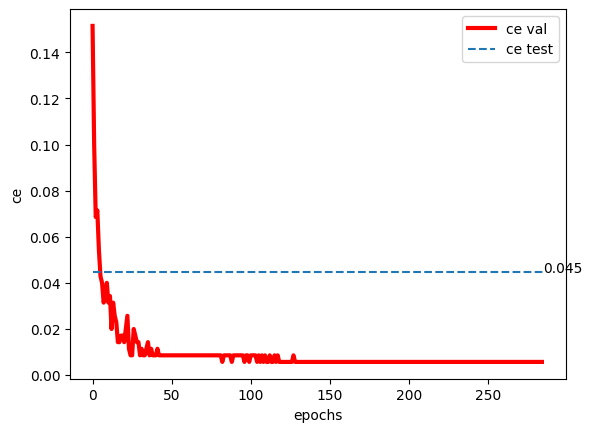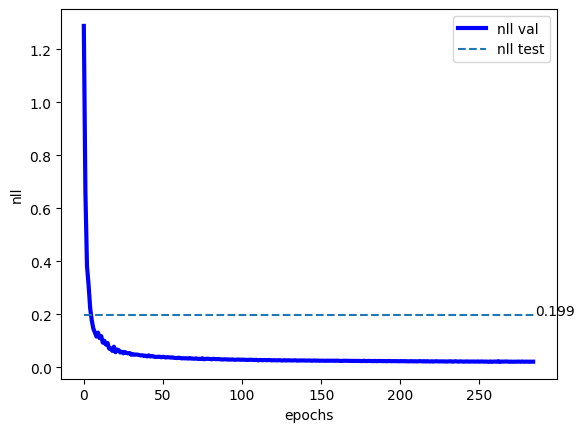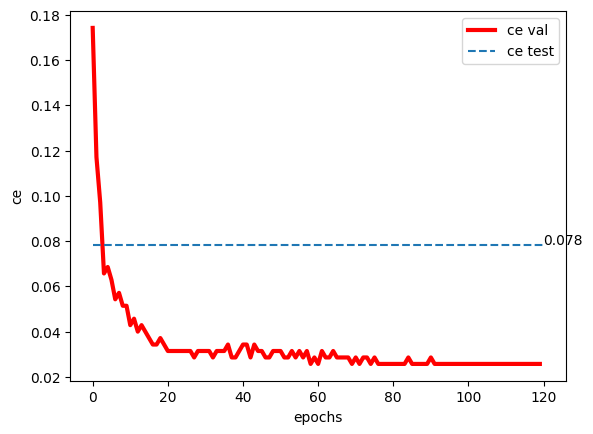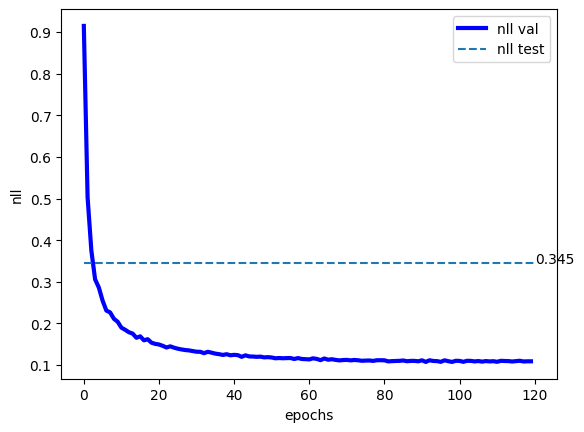

**Answer**:  We have the results for classifier_mlp FINAL PERFORMANCE: nll=0.34455900117588256, ce=0.07829977628635347, for classifier_cnn FINAL PERFORMANCE:  nll=0.19896060375025876, ce=0.0447427293064877. We see that the cnn model has nll (negative log likelihood) value approximately 0.19, whereas mlp model has nll (negative log likelihood) value approximately 0.34. This difference shows that cnn obtains better results and has better probability distribution compared to mlp model. The classification error is very similar in both models, there is a correctness of classification more than 90%. In conclusion, we understand that the cnn model converges better and faster to the solution.

**Question 4 (0-0.5pt)**: In general, for a properly picked architectures, a CNN should work better than an MLP. Did you notice that? Why (in general) CNNs are better suited to images than MLPs?

Yes, I noticed that the cnns work better in terms of images compared to mlp architecture. It can be seen from the convergence graphs above. Cnns converges to better results compared to mlps also it converges faster. It is because of the fact that cnns are well designed commonly used for image classification. This is because mlps take inputs as a flat vector and fails to do spatial correlations which needs to be done in images. On the other hand, cnns can extract spatial relations and understand patterns in the images with convolutional layer structure. Flattening vectors in mlps makes it fail for image classification tasks. However, mlp s can perform better on flattened vectors with non spatial data. 

## 3 Application to Street House View Numbers (SVHN) (6pt)

Please repeat (some) of the code in the previous section and apply a bigger convolutional neural network (CNN) to the following dataset:

http://ufldl.stanford.edu/housenumbers/

Please follow the following steps:
1. (1pt) Create appropriate Dataset class. Please remember to use the original training data and test data, and also to create a validation set from the traning data (at least 10% of the training examples). **Do not use extra examples!**
2. (1pt) Implement an architecture that will give at most 0.1 classification error. For instance, see this paper as a reference: https://arxiv.org/pdf/1204.3968.pdf#:~:text=The%20SVHN%20classification%20dataset%20%5B8,set%20of%20more%20difficult%20samples
3. (1pt) Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).
4. (1pt) Provide a good explanation of the applied architecture and a description of all components.
5. (2pt) Analyze the results.

**Please be very precise, comment your code and provide a comprehensive and clear analysis.**

1.(1pt) Create appropriate Dataset class.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import SVHN
from torchvision import transforms
from torchvision.transforms import ToTensor

In [ ]:
#class for SVHN Dataset
class SVHNDataset(Dataset):
    def __init__(self, mode="train", transforms=None):
        self.mode = mode
        self.transforms = transforms   #transforms to the images  
        if mode == "train":
           self.dataset = SVHN(root="./data", split="train", download=True)
        #split training dataset to create validation dataset
        elif mode == "val":
            self.dataset = SVHN(root="./data", split="train", download=True)
            self.dataset.data = self.dataset.data[50000:]
            self.dataset.labels = self.dataset.labels[50000:]
        else: #split test data
            self.dataset = SVHN(root="./data", split="test", download=True)
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index] #get image and label with index
        if self.transforms:
            image = self.transforms(image)
        return (image, label)

In [ ]:
train_data = SVHNDataset(mode="train", transforms=transforms.Compose([ToTensor()]))
val_data = SVHNDataset(mode="val",  transforms=transforms.Compose([ToTensor()]))
test_data = SVHNDataset(mode="test",  transforms=transforms.Compose([ToTensor()]))

# dataloaders 
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

100%|██████████| 182040794/182040794 [00:05<00:00, 30689204.66it/s]


Using downloaded and verified file: ./data/train_32x32.mat


100%|██████████| 64275384/64275384 [00:03<00:00, 19812936.08it/s]


In [ ]:
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1][0]}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: tensor([[[0.3294, 0.3373, 0.3020,  ..., 0.3529, 0.3451, 0.3451],
         [0.3333, 0.3255, 0.2902,  ..., 0.3490, 0.3451, 0.3451],
         [0.3255, 0.3059, 0.2392,  ..., 0.3529, 0.3451, 0.3333],
         ...,
         [0.3922, 0.3843, 0.3725,  ..., 0.4078, 0.4000, 0.3922],
         [0.4039, 0.4157, 0.4039,  ..., 0.4039, 0.4039, 0.4118],
         [0.4039, 0.4039, 0.4078,  ..., 0.4431, 0.4078, 0.4039]],

        [[0.2980, 0.2863, 0.3059,  ..., 0.3059, 0.3020, 0.3059],
         [0.3020, 0.2863, 0.2706,  ..., 0.3216, 0.3098, 0.3176],
         [0.2980, 0.3020, 0.1961,  ..., 0.3333, 0.3255, 0.3216],
         ...,
         [0.3843, 0.3686, 0.3647,  ..., 0.4078, 0.4000, 0.3961],
         [0.4078, 0.4078, 0.4039,  ..., 0.4078, 0.4039, 0.3882],
         [0.4157, 0.4118, 0.4157,  ..., 0.4039, 0.4078, 0.3843]],

        [[0.2314, 0.2588, 0.2196,  ..., 0.2706, 0.2627, 0.2588],
         [0.2392, 0.2510, 0.2314,  ..., 0.2510, 0.2745, 0.2627

2. (1pt) Implement an architecture that will give at most 0.1 classification error.

In [ ]:
class SVHNClassifierNeuralNet(nn.Module):
    def __init__(self):
        super(SVHNClassifierNeuralNet, self).__init__()
        # convolutional layers are added with nn.Sequential
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)) #relu activation function is used 
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)) #relu activation function is used 
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)) #relu activation function is used 
        # fully connected layers are defined 
        self.fc1 = nn.Sequential(
            nn.Linear(2048, 256),
            nn.ReLU(inplace=True))   #relu activation function is used   
        self.fc2 = nn.Linear(256, 10)
        # pooling layer with maxpool2d
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # dropout is used to improve the performance
        self.dropout = nn.Dropout(p=0.2)
        # nll loss function is defined to calculate loss
        #the negative log-likelihood dfunction
        self.nll = nn.NLLLoss(reduction="none")

    def forward(self, x, y, reduction="avg"):
        # forward method
        # we get the output
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = x.view(-1, 2048)
        x = self.dropout(self.fc1(x))
        x = self.fc2(x)
        #we calculate loss with nllloss function between y and output
        loss = self.nll(F.log_softmax(x, dim=1), y)
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

    def classify(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = x.view(-1, 2048)
        x = self.dropout(self.fc1(x))
        x = self.fc2(x)
        # index of maximum value and assign it to predicted one
        x = F.log_softmax(x, dim=1)
        _, y_pred = x.max(dim=1)
        #return predicted label
        return y_pred

In [ ]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64  # input dimension

# -> model hyperparams
M = 512  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 100  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [ ]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        test_batch, test_targets = test_batch.to('cuda'), test_targets.to('cuda')
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

In [ ]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            batch, targets = batch.to('cuda'), targets.to('cuda')
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

In [ ]:
result_dir = "/content/gdrive/MyDrive/Colab Notebooks/SVHN_results"  # (current folder)
    # =========
if not (os.path.exists(result_dir)):
  os.mkdir(result_dir)

Epoch: 0, val nll=0.4130959940955159, val ce=0.11768499806509868
Epoch: 10, val nll=0.1279051861287537, val ce=0.03629014920239068
Epoch: 20, val nll=0.045827069363633725, val ce=0.011953390377090768
Epoch: 30, val nll=0.017356116750820227, val ce=0.0040417938685127055
Epoch: 40, val nll=0.0060467158434254625, val ce=0.000859956142236746
Epoch: 50, val nll=0.0021693621043672637, val ce=0.0002149890355591865
Epoch: 60, val nll=0.0018502991192039463, val ce=0.00012899342133551188
Epoch: 70, val nll=0.0020420214672158725, val ce=0.0005589714924538849
Epoch: 80, val nll=0.0010219937310703133, val ce=8.599561422367459e-05
Epoch: 90, val nll=0.0010279807729350672, val ce=0.00012899342133551188
-> FINAL PERFORMANCE: nll=0.6036235449690264, ce=0.07909496004917026


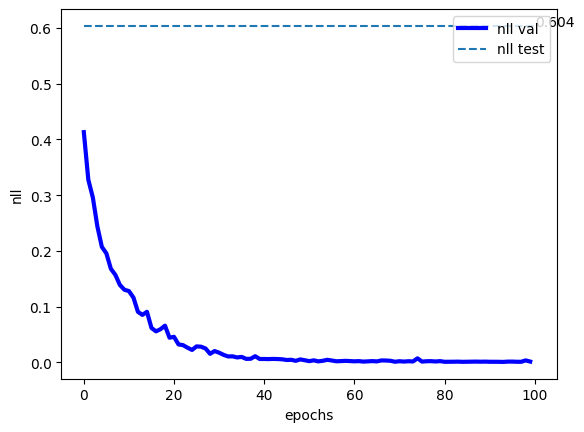

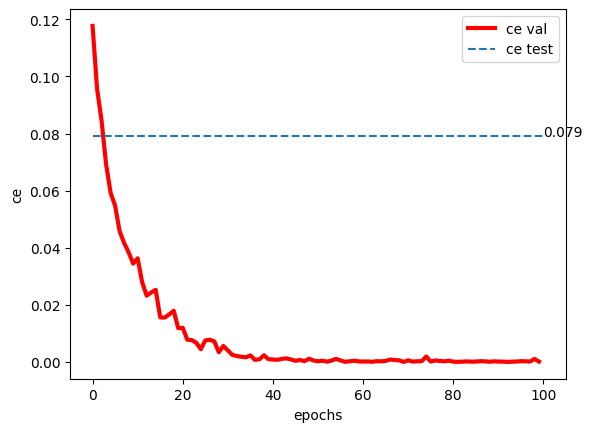

In [ ]:
 # Init ClassifierNN
model = SVHNClassifierNeuralNet().to('cuda') #used gpu for training

# Init OPTIMIZER (here we use ADAMAX)
optimizer = torch.optim.Adamax(
    [p for p in model.parameters() if p.requires_grad == True],
    lr=lr,
    weight_decay=wd,
)

name = "classifier" 

# Training procedure
nll_val, error_val = training(
    name=result_dir + name,
    max_patience=max_patience,
    num_epochs=num_epochs,
    model=model,
    optimizer=optimizer,
    training_loader=train_loader,
    val_loader=val_loader,
)

# The final evaluation (on the test set)
test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
# write the results to a file
f = open(result_dir + name + "_test_loss.txt", "w")
f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
f.close()
# create curves
plot_curve(
    result_dir + name,
    nll_val,
    file_name="_nll_val_curve.pdf",
    ylabel="nll",
    test_eval=test_loss,
)
plot_curve(
    result_dir + name,
    error_val,
    file_name="_ca_val_curve.pdf",
    ylabel="ce",
    color="r-",
    test_eval=test_error,
)

3. (1pt) Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).

We can add dropout regularization to the model to improve the performance. Dropout regularization, drops out random neurons during the training. Dropout regularization improves the performance as it prevents overfitting during training. With regularization, neurons have a probability of being 0 during training. Weight decay could also be used to make weights lower. In this classifier model, ReLU activation function is used. Different activation functions such as leaky ReLU and sigmoid activation function could be used to improve the performance. In addition, L2 regularization could be added to the forward method of our model to improve the performance (faster convergence and better classification results). L2 is used for the model not to be overfit.  

4. (1pt) Provide a good explanation of the applied architecture and a description of all components.

We applied the SVHNClassifierNeuralNet as a convolutional neural network for the SVHN Dataset. The CNN architecture has 3 convolutional layers. For each of these convolutional layers we applied nn.BatchNorm2d batch normalization and nn.ReLU() relu activation function. The CNN has 2 fully connected layers, ReLu activation function, dropout regularization, max pooling with kernel 2 and negative log likelihood function. 

*   conv1: 3 input channels, 32 output channels. batch normalization is 64. relu activation function is used. 
*   conv2: 32 input channels, 64 output channels, batch normalization is 64. relu activation function is used. 
*   conv3: 64 input channels, 128 output channels and batch normalization is 128. relu activation function is used. 
*   max pooling: is used after the convolutional layers with kernel size 2. this increases the performance by reducing the dimensionality.
*   fully connected layer fc1: 256 units. relu is used. 
*   fully connected layer fc2: 10 units. relu is not used in this layer.
*   loss function: NLLLoss is used negative loss likelihood function, and the input of it should be log softmax function. it gives the difference between predicted and real labels.
*   dropout regularization: 20% dropout regularization is used to improve the performance. It is used after the third convolutional layer is flattened and then put into the fully connected layer fc1. this reduces overfitting.
*   init method: initializes convolutional layers, fully connected layers, dropout, pool and loss functions. 
*   classify method: the input is an image and the method returns the predicted class label.  uses convolutional layers, pooling, flattening, dropout and fully connected layers to find the output. it finds the maximum value and assigns this value to the predicted label. 
*   forward method:  uses convolutional layers, pooling, flattening, dropout and fully connected layers to find the output, then it calculates the loss with negative log likelihood function as sum of the losses or mean of the losses. 


5. (2pt) Analyze the results.


We obtained these results during training: Epoch: 0, val nll=0.4130959940955159, val ce=0.11768499806509868
Epoch: 10, val nll=0.1279051861287537, val ce=0.03629014920239068
Epoch: 20, val nll=0.045827069363633725, val ce=0.011953390377090768
Epoch: 30, val nll=0.017356116750820227, val ce=0.0040417938685127055
Epoch: 40, val nll=0.0060467158434254625, val ce=0.000859956142236746
Epoch: 50, val nll=0.0021693621043672637, val ce=0.0002149890355591865
Epoch: 60, val nll=0.0018502991192039463, val ce=0.00012899342133551188
Epoch: 70, val nll=0.0020420214672158725, val ce=0.0005589714924538849
Epoch: 80, val nll=0.0010219937310703133, val ce=8.599561422367459e-05
Epoch: 90, val nll=0.0010279807729350672, val ce=0.00012899342133551188
-> FINAL PERFORMANCE: nll=0.6036235449690264, ce=0.07909496004917026

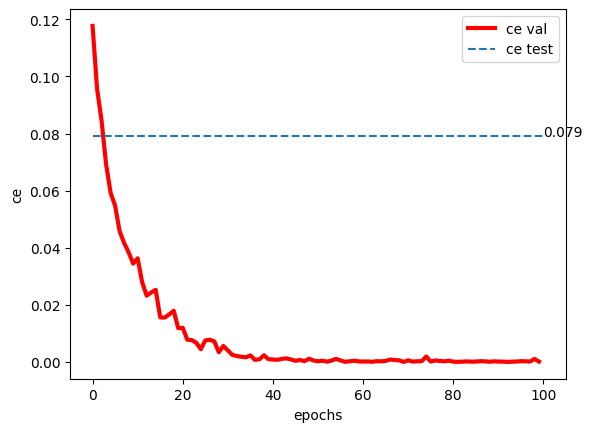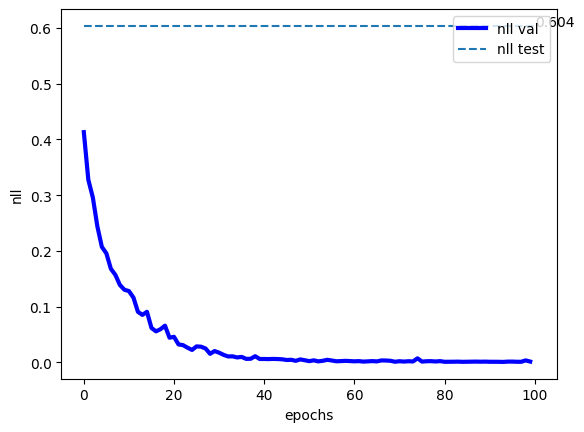

The model has the final performance of negative loss likelihood function approximately nll = 0.6 and the classification error approximately ce=0.08. The low nll shows that the model has a good performance predicting the labels. The nll and the ce decreased with each epoch except for the epoch 80. This difference in the epoch demonstartes that there was overfitting before the end of the training. So it is better to stop the training before the 80th epoch to avoid overfitting. The constant decrease shows that the model learned to classify correctly within the epochs. The low classification error which is below 1% shows that the model accurately predicts the labels. The convolutional neural network has good performance overall. 